# ConvNEXT for DR detection

## Setup

### Google Drive Access

In [1]:
from google.colab import drive
import os

# Parameters
DATASET_PATH = '/content/drive/My Drive/University Of Stirling/Dissertation/ConvNEXT/APTOS2019'
PREP_PATH = DATASET_PATH + '/preprocessed_2/'
MODEL_PATH= '/content/drive/My Drive/University Of Stirling/Dissertation/ConvNEXT/checkpoints/checkpoint.pth'

# Load Dataset From Drive
drive.mount('/content/drive')

os.chdir(DATASET_PATH)
print("CWD:",os.getcwd())

if not os.path.exists(PREP_PATH):
  os.mkdir(PREP_PATH)

Mounted at /content/drive
CWD: /content/drive/My Drive/University Of Stirling/Dissertation/ConvNEXT/APTOS2019


### Dataset Download

In [ ]:
'''
# Dataset with already preprocessed images
!gdown --id 1TqlyF-VVLcuebqQcWuAKnG7ay3IKjylC
!unzip APTOS2019.zip

# Parameters
DATASET_PATH = '/content/APTOS2019'
PREP_PATH = DATASET_PATH + "/preprocessed/"
MODEL_PATH= '/content/checkpoints/checkpoint.pth'

if not os.path.exists(PREP_PATH):
  os.mkdir(PREP_PATH)

if not os.path.exists("/checkpoints"):
  os.mkdir("/checkpoints")
'''

'\n# Dataset with already preprocessed images\n!gdown --id 1TqlyF-VVLcuebqQcWuAKnG7ay3IKjylC\n!unzip APTOS2019.zip\n\n# Parameters\nDATASET_PATH = \'/content/APTOS2019\'\nPREP_PATH = DATASET_PATH + "/preprocessed/"\nMODEL_PATH= \'/content/checkpoints/checkpoint.pth\'\n\nif not os.path.exists(PREP_PATH):\n  os.mkdir(PREP_PATH)\n\nif not os.path.exists("/checkpoints"):\n  os.mkdir("/checkpoints")\n'

### Environment Setup

In [2]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Imports and global parameters

In [2]:
import pandas as pd
import cv2
import numpy as np
import os
from sklearn.model_selection import train_test_split
import shutil
import torch
import torchvision
from torchvision.models import ConvNeXt_Tiny_Weights
from torch import nn
from torchvision.io import read_image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader 
from torch.utils.data import WeightedRandomSampler
from torch.utils.data import random_split
import torchvision.transforms as transforms
from matplotlib import pyplot as plt 

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
IMG_SIZE = 512
BATCH_SIZE = 10
NUM_EPOCHS = 30
NUM_INIT_EPOCHS = 4
LR_INIT = 0.0001
LR = 0.0001
DECAY_FACTOR = 0.1
PATIENCE = 3
ES_PATIENCE = 3
LR_TSH = 0.000001
TSH_MODE = 'abs'
N_CLASSES = 5
CLASSES = [ "No DR", "Mild", "Moderate", "Severe", "Proliferative DR" ]

## Dataset Preparation

In [ ]:
import multiprocessing
from multiprocessing.pool import ThreadPool

# ref: https://www.kaggle.com/code/ratthachat/aptos-eye-preprocessing-in-diabetic-retinopathy/notebook
# ref: https://www.kaggle.com/code/ratthachat/aptos-eye-preprocessing-in-diabetic-retinopathy/notebook
# ref for circle crop: https://github.com/debayanmitra1993-data/Blindness-Detection-Diabetic-Retinopathy-/blob/master/research_paper_implementation.ipynb
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

def circle_crop(img, sigmaX = 30):   
    """
    Create circular crop around image centre    
    """    
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

def preprocess(id_code):
  path = DATASET_PATH + "/train_images/" + id_code + ".png"

  if(os.path.isfile(path) == False):
    print(id_code + " does not exist!")
    return

  img = cv2.imread(path)

  # Circle crop
  img = circle_crop(img)

  cv2.imwrite(PREP_PATH + id_code + ".png", cv2.resize(img, (IMG_SIZE,IMG_SIZE)))


def multiprocessor(process:int, imgs:list):
    """
    Inputs:
        process: (int) number of process to run
        imgs:(list) list of images
    """
    print(f'MESSAGE: Running {process} process')
    results = ThreadPool(process).map(preprocess, imgs)
    return results

dataset = pd.read_csv("train.csv")

multiprocessor(4, list(dataset.id_code.values))


MESSAGE: Running 4 process


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [4]:
# https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

class DrDetectionDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.labels = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        path = os.path.join(self.root_dir, self.labels.iloc[idx, 0])
        img = read_image(path + ".png")
        lbl = self.labels.iloc[idx, 1]
        if self.transform:
            img = self.transform(img)
        return img, lbl

global_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Lambda(lambda image: image.convert('RGB')),
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.5413734, 0.5413734, 0.5413734], [0.17313044, 0.17313044, 0.17313044])
    ])

train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Lambda(lambda image: image.convert('RGB')),
    # Data Augmentation
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.5413734, 0.5413734, 0.5413734], [0.17313044, 0.17313044, 0.17313044])
    ])

dataset = DrDetectionDataset(DATASET_PATH + "/train.csv", PREP_PATH, transform = global_transforms)

In [9]:
#Train-test-validation split

# Set manual seed for reproducible results
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# 60% train, 20% test, 20% valid
train_size = int(0.8 * len(dataset))
test_val_size = (len(dataset) - train_size)

train_dataset, test_dataset = random_split(dataset, [train_size, test_val_size])

train_size = int(len(train_dataset) - test_val_size)
train_dataset, valid_dataset = random_split(train_dataset, [train_size, test_val_size])

train_dataset.dataset.dataset.transform = train_transforms
'''
# Use a Weighted Sampler to fix class imbalances in the training set
class_count = np.zeros(5)
for image, label in train_dataset:
  class_count[label] +=1

class_weights = 1. / class_count
weights = np.array([])

for image, label in train_dataset:
  weights = np.append(weights, class_weights[label])
  
weights = torch.from_numpy(weights)

weighted_sampler = WeightedRandomSampler(weights=weights,num_samples=len(train_dataset),replacement=True)

print("Train size: ", len(train_dataset))
print("Val size: ", len(valid_dataset))
print("Test size: ", len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=weighted_sampler)
'''
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)


# Training

## Get Model

In [ ]:
#https://www.learnpytorch.io/06_pytorch_transfer_learning/
from torchinfo import summary

# Download pre-trained weights on IMAGENET
weights = ConvNeXt_Tiny_Weights.IMAGENET1K_V1

model = torchvision.models.convnext_tiny(weights = weights).to(device)
print("Base Model: ")
print(summary(model=model, 
        input_size=(BATCH_SIZE, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]) )

Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth


  0%|          | 0.00/109M [00:00<?, ?B/s]

Base Model: 
Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
ConvNeXt (ConvNeXt)                                     [10, 3, 224, 224]    [10, 1000]           --                   True
├─Sequential (features)                                 [10, 3, 224, 224]    [10, 768, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                         [10, 3, 224, 224]    [10, 96, 56, 56]     --                   True
│    │    └─Conv2d (0)                                  [10, 3, 224, 224]    [10, 96, 56, 56]     4,704                True
│    │    └─LayerNorm2d (1)                             [10, 96, 56, 56]     [10, 96, 56, 56]     192                  True
│    └─Sequential (1)                                   [10, 96, 56, 56]     [10, 96, 56, 56]     --                   True
│    │    └─CNBlock (0)                                 [10, 96, 56, 56]     [10, 96, 56, 56]     79,296          

In [ ]:
from torchinfo import summary

# Tune the model parameters to fit our domain
# Sets Feature extraction layers as not trainable
for param in model.features.parameters():
    param.requires_grad = False
    
model.classifier[2] = torch.nn.Linear(in_features=768, out_features=5, bias=True)

print(summary(model=model, 
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]))

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
ConvNeXt (ConvNeXt)                                     [32, 3, 224, 224]    [32, 5]              --                   Partial
├─Sequential (features)                                 [32, 3, 224, 224]    [32, 768, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                         [32, 3, 224, 224]    [32, 96, 56, 56]     --                   False
│    │    └─Conv2d (0)                                  [32, 3, 224, 224]    [32, 96, 56, 56]     (4,704)              False
│    │    └─LayerNorm2d (1)                             [32, 96, 56, 56]     [32, 96, 56, 56]     (192)                False
│    └─Sequential (1)                                   [32, 96, 56, 56]     [32, 96, 56, 56]     --                   False
│    │    └─CNBlock (0)                                 [32, 96, 56, 56]     [32, 96, 56, 56]     (79,296)             

## Train

### Warmup Training

In [ ]:
#https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
#https://www.geeksforgeeks.org/training-neural-networks-with-validation-using-pytorch/

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR_INIT)

top_accuracy = 0.0

# Loop through each epoch
for epoch in range(NUM_INIT_EPOCHS):
  train_loss = 0.0
  
  train_correct = 0
  train_total = 0

  for data, labels in train_loader:
    if torch.cuda.is_available():
        data, labels = data.cuda(), labels.cuda()

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(data)
    loss = loss_fn(outputs, labels)
    loss.backward()
    optimizer.step()

    _, predicted = torch.max(outputs.data, 1)
    train_total += labels.size(0)
    train_correct += (predicted == labels).sum().item()

    # print statistics
    train_loss += loss.item()
    
  valid_loss = 0.0
  val_correct = 0
  val_total = 0

  for data, labels in valid_loader:
    if torch.cuda.is_available():
      data, labels = data.cuda(), labels.cuda()

      outputs = model(data)
      loss = loss_fn(outputs,labels)
      valid_loss = loss.item() * data.size(0)

      _, predicted = torch.max(outputs.data, 1)
      val_total += labels.size(0)
      val_correct += (predicted == labels).sum().item()

  val_accuracy = (100 * val_correct) // val_total

  print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(train_loader)} \t\t Training Accuracy: {100 * train_correct // train_total}' )
  print(f'\t\t Validation Loss: {valid_loss / len(valid_loader)} \t\t Validation Accuracy: {val_accuracy}')
  if val_accuracy > top_accuracy:
      print(f'Validation Accuracy Increased({top_accuracy:.6f}--->{val_accuracy:.6f}) \t Saving The Model')
      top_accuracy = val_accuracy
      # Save Model
      torch.save(model, MODEL_PATH)


Epoch 1 		 Training Loss: 1.491583394462412 		 Training Accuracy: 38
		 Validation Loss: 0.05583290634928523 		 Validation Accuracy: 56
Validation Accuracy Increased(0.000000--->56.000000) 	 Saving The Model
Epoch 2 		 Training Loss: 1.3206031793897801 		 Training Accuracy: 51
		 Validation Loss: 0.05875518032022425 		 Validation Accuracy: 65
Validation Accuracy Increased(56.000000--->65.000000) 	 Saving The Model
Epoch 3 		 Training Loss: 1.2283531538464807 		 Training Accuracy: 54
		 Validation Loss: 0.04652831844381384 		 Validation Accuracy: 66
Validation Accuracy Increased(65.000000--->66.000000) 	 Saving The Model
Epoch 4 		 Training Loss: 1.1642900388349187 		 Training Accuracy: 55
		 Validation Loss: 0.042574491049792315 		 Validation Accuracy: 64


### Training

In [ ]:
#https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
#https://www.geeksforgeeks.org/training-neural-networks-with-validation-using-pytorch/
#https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch
#https://clay-atlas.com/us/blog/2021/08/25/pytorch-en-early-stopping/

model = torch.load(MODEL_PATH).to(device)

# Tune the model parameters to fit our domain
# Sets Feature extraction layers as not trainable
for param in model.features.parameters():
    param.requires_grad = True

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=DECAY_FACTOR, patience=0, 
                                                       threshold=LR_TSH, threshold_mode=TSH_MODE, verbose=True)

prev_valid_loss = 100
trigger_times = 0

# Loop through each epoch
for epoch in range(NUM_EPOCHS):
  train_loss = 0.0

  train_correct = 0
  train_total = 0

  for data, labels in train_loader:

    if torch.cuda.is_available():
        data, labels = data.cuda(), labels.cuda()

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(data)
    loss = loss_fn(outputs, labels)
    loss.backward()
    optimizer.step()

    _, predicted = torch.max(outputs.data, 1)
    train_total += labels.size(0)
    train_correct += (predicted == labels).sum().item()

    # print statistics
    train_loss += loss.item()
    
  valid_loss = 0.0
  val_correct = 0
  val_total = 0

  with torch.no_grad():
    for data, labels in valid_loader:
      if torch.cuda.is_available():
        data, labels = data.cuda(), labels.cuda()

        outputs = model(data)
        loss = loss_fn(outputs,labels)
        valid_loss = loss.item() * data.size(0)

        _, predicted = torch.max(outputs.data, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()
  

  # Early stopping
  if valid_loss > prev_valid_loss:
    trigger_times += 1
    print('trigger times:', trigger_times)

    if trigger_times >= ES_PATIENCE:
      print('Early stopping!')
      break

  else:
    trigger_times = 0

  prev_valid_loss = valid_loss

  scheduler.step(valid_loss)

  val_accuracy = (100 * val_correct) // val_total

  print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(train_loader)} \t\t Training Accuracy: {100 * train_correct // train_total}' )
  print(f'\t\t Validation Loss: {valid_loss / len(valid_loader)} \t\t Validation Accuracy: {val_accuracy}')
  if val_accuracy > top_accuracy:
      print(f'Validation Accuracy Increased({top_accuracy:.6f}--->{val_accuracy:.6f}) \t Saving The Model')
      top_accuracy = val_accuracy
      # Save Model
      torch.save(model, MODEL_PATH)


Epoch 1 		 Training Loss: 0.9171756795861504 		 Training Accuracy: 61
		 Validation Loss: 0.031229604740400572 		 Validation Accuracy: 66
Epoch 2 		 Training Loss: 0.5975974245843563 		 Training Accuracy: 77
		 Validation Loss: 0.016971052901164907 		 Validation Accuracy: 78
Validation Accuracy Increased(66.000000--->78.000000) 	 Saving The Model
Epoch 3 		 Training Loss: 0.40347710661590097 		 Training Accuracy: 84
		 Validation Loss: 0.00036335006557606364 		 Validation Accuracy: 74
trigger times: 1
Epoch 00004: reducing learning rate of group 0 to 1.0000e-05.
Epoch 4 		 Training Loss: 0.25927111317657614 		 Training Accuracy: 91
		 Validation Loss: 0.08953118002092517 		 Validation Accuracy: 78
trigger times: 2
Epoch 00005: reducing learning rate of group 0 to 1.0000e-06.
Epoch 5 		 Training Loss: 0.13708315155130218 		 Training Accuracy: 95
		 Validation Loss: 0.09712858780010326 		 Validation Accuracy: 80
Validation Accuracy Increased(78.000000--->80.000000) 	 Saving The Model
Epo

# Test on whole test-set

In [ ]:
#https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
model = torch.load(MODEL_PATH).to(device)

correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        # the class with the highest value is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print(f'Accuracy on the 733 test images: {100 * correct // total} %')

Accuracy on the 733 test images: 82 %


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in CLASSES}
total_pred = {classname: 0 for classname in CLASSES}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[CLASSES[label]] += 1
            total_pred[CLASSES[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: No DR is 98.3 %
Accuracy for class: Mild  is 66.7 %
Accuracy for class: Moderate is 74.6 %
Accuracy for class: Severe is 42.1 %
Accuracy for class: Proliferative DR is 44.0 %


# GradCAM

In [34]:
#https://github.com/jacobgil/pytorch-grad-cam
!pip install grad-cam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.1 MB 6.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.2-py3-none-any.whl size=32305 sha256=47aa7cb7369eff43b4bfe1bda058673552af45a503c850f7c3dc77a4bf83bba3
  Stored in directory: /root/.cache/pip/wheels/a0/9c/d6/980994b42f520eade90b6d5c7e2613dad62d50d2497820d208
Successfully built grad-cam


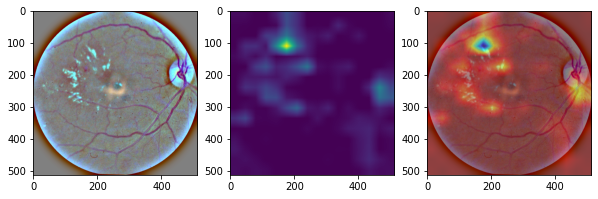

In [92]:
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

model = torch.load(MODEL_PATH).to(device)

model.eval()

target_layers = [model.features[-1]]
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)

rgb_img = cv2.imread(PREP_PATH + "dc3c0d8ee20b.png", cv2.COLOR_BGR2RGB)[:, :, ::-1]
rgb_img = cv2.resize(rgb_img, (IMG_SIZE, IMG_SIZE))
rgb_img = np.float32(rgb_img) / 255
input_tensor = preprocess_image(rgb_img, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])

# If None, returns the map for the highest scoring category.
# Otherwise, targets the requested category.
targets = None

grayscale_cam = cam(input_tensor=input_tensor, targets=targets , eigen_smooth=False, aug_smooth=False)

# Here grayscale_cam has only one image in the batch
grayscale_cam = grayscale_cam[0, :]

cam_image = show_cam_on_image(rgb_img, grayscale_cam)

plt.rcParams["figure.figsize"] = (10,10)
fig, ax = plt.subplots(1,3)

ax[0].imshow(rgb_img)
ax[1].imshow(grayscale_cam)
ax[2].imshow(cam_image)


#cv2.imwrite(f'{args.method}_cam.jpg', cam_image)


# GradCAM++

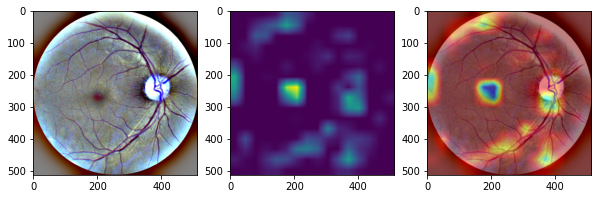

In [90]:
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

model = torch.load(MODEL_PATH).to(device)

model.eval()

target_layers = [model.features[-1]]
cam = GradCAMPlusPlus(model=model, target_layers=target_layers, use_cuda=True)

rgb_img = cv2.imread(PREP_PATH + "edceb0657d77.png", cv2.COLOR_BGR2RGB)[:, :, ::-1]
rgb_img = cv2.resize(rgb_img, (IMG_SIZE, IMG_SIZE))
rgb_img = np.float32(rgb_img) / 255
input_tensor = preprocess_image(rgb_img, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])

# If None, returns the map for the highest scoring category.
# Otherwise, targets the requested category.
targets = None

grayscale_cam = cam(input_tensor=input_tensor, targets=targets , eigen_smooth=False, aug_smooth=False)

# Here grayscale_cam has only one image in the batch
grayscale_cam = grayscale_cam[0, :]

cam_image = show_cam_on_image(rgb_img, grayscale_cam)

plt.rcParams["figure.figsize"] = (10,10)
fig, ax = plt.subplots(1,3)

ax[0].imshow(rgb_img)
ax[1].imshow(grayscale_cam)
ax[2].imshow(cam_image)


#cv2.imwrite(f'{args.method}_cam.jpg', cam_image)
